### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [1]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-oavv082g
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-oavv082g
     |████████████████████████████████| 47.6 MB 3.8 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112538 sha256=a8b255d4d3f95a82fd7892d9b95acffef155dae6e7dbffd5c0c9bd151508a4fd
  Stored in directory: /tmp/pip-ephem-wheel-cache-vmrjk14_/wheels/63/11/1a/c77caf3ae9b9b6d57b3ee5e6a41a50f3bc12c66a70f6b90bf0
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-zdybaqkj
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-zdybaqkj
  Running command git submodule update --init --recursive 

In [2]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
%cd ./gdrive/MyDrive/segmentation

/content/gdrive/MyDrive/segmentation


In [ ]:
ls

'=0.3.0'   gdrive/   sample_data/


# Loading dataset

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

In [7]:
DATA_DIR = './data/'

# Dataloader and utility functions

In [9]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['solar_panel']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id.split('.')[0]+'_label.png') for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i],0)
        mask=cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)[1]
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloader(tf.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.


In [11]:
import albumentations as A

In [13]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
        A.RandomCrop(height=256, width=256, always_apply=True),

        A.GaussNoise(p=0.2),
        #A.Perspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        #A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(256, 256)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

# Segmentation model training

In [17]:
import segmentation_models as sm
sm.set_framework('tf.keras') 
#sm.framework()
# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

'tf.keras'

In [8]:
x_train_dir = os.path.join(DATA_DIR, 'train/images')
y_train_dir = os.path.join(DATA_DIR, 'train/masks')

x_valid_dir = os.path.join(DATA_DIR, 'val/images')
y_valid_dir = os.path.join(DATA_DIR, 'val/masks')

x_test_dir = os.path.join(DATA_DIR, 'test/images')
y_test_dir = os.path.join(DATA_DIR, 'test/masks')

In [18]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['solar_panel']
LR = 0.0001
EPOCHS = 2

preprocess_input = sm.get_preprocessing(BACKBONE)

In [19]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

44122112/44107200 [==============================] - 1s 0us/step


In [21]:
# define optimizer
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimizer, loss and metrics
model.compile(optim, total_loss, metrics)

In [22]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloader(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=False, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:262: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1606: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:232: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1632: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [23]:
# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=5, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/5
297/297 [==============================] - 1249s 4s/step - loss: 0.2569 - iou_score: 0.8195 - f1-score: 0.8946 - val_loss: 0.1228 - val_iou_score: 0.9161 - val_f1-score: 0.9493 - lr: 1.0000e-04
Epoch 2/5
297/297 [==============================] - 209s 704ms/step - loss: 0.1516 - iou_score: 0.8884 - f1-score: 0.9385 - val_loss: 0.1006 - val_iou_score: 0.9241 - val_f1-score: 0.9548 - lr: 1.0000e-04
Epoch 3/5
297/297 [==============================] - 210s 706ms/step - loss: 0.1186 - iou_score: 0.9102 - f1-score: 0.9513 - val_loss: 0.0907 - val_iou_score: 0.9347 - val_f1-score: 0.9619 - lr: 1.0000e-04
Epoch 4/5
297/297 [==============================] - 210s 705ms/step - loss: 0.1062 - iou_score: 0.9180 - f1-score: 0.9554 - val_loss: 0.0794 - val_iou_score: 0.9341 - val_f1-score: 0.9614 - lr: 1.0000e-04
Epoch 5/5
297/297 [==============================] - 209s 703ms/step - loss: 0.0856 - iou_score: 0.9320 - f1-score: 0.9639 - val_loss: 0.0726 - val_iou_score: 0.9429 - val_f1-sco

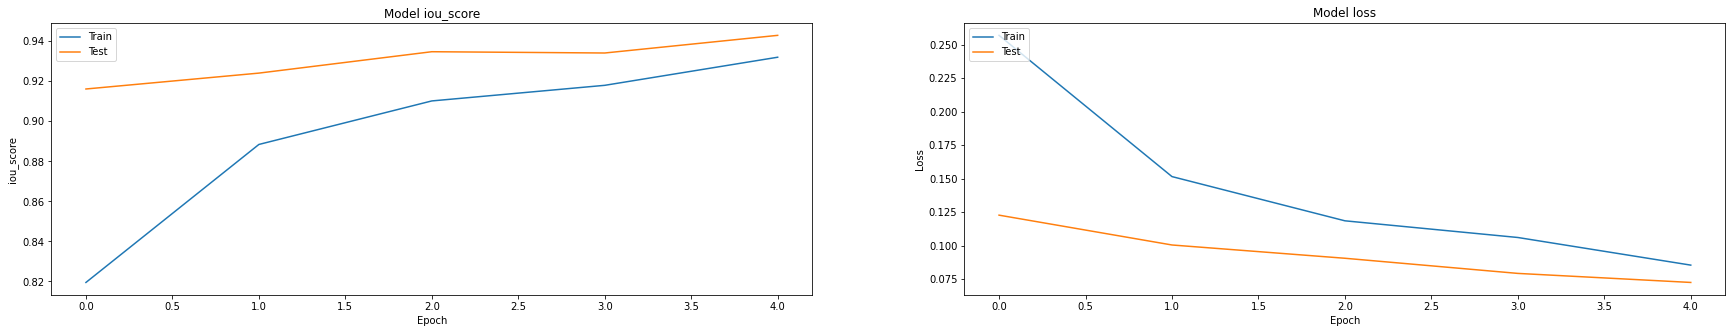

In [24]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model Evaluation

In [25]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloader(test_dataset, batch_size=1, shuffle=False)

In [26]:
# load best weights
model.load_weights('best_model.h5') 

In [27]:
scores = model.evaluate(test_dataloader)

print(f"Loss: {scores[0]:.5}")
for metric, value in zip(metrics, scores[1:]):
    print(f"mean {metric.__name__}: {value:.5}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.073604
mean iou_score: 0.94322
mean f1-score: 0.96824


# Visualization of results on test dataset

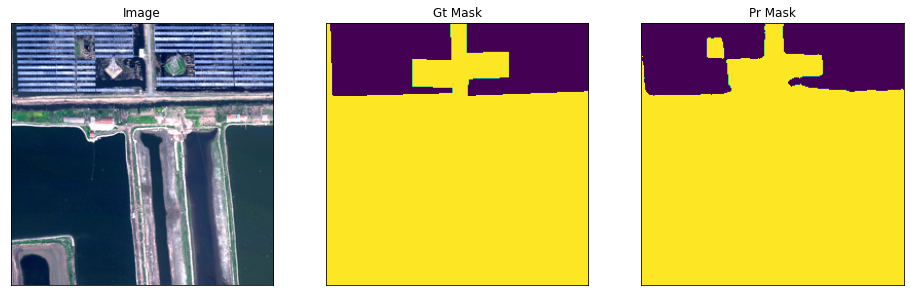

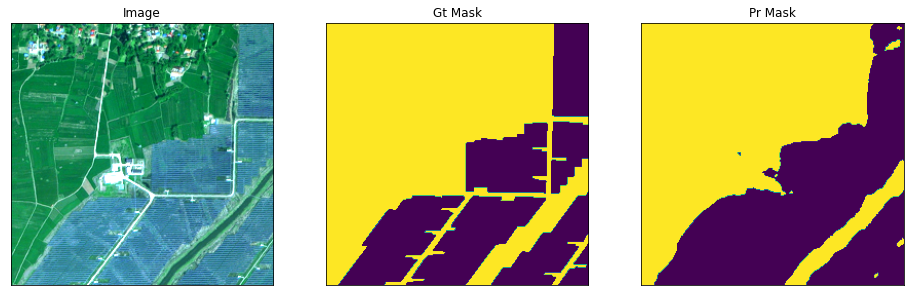

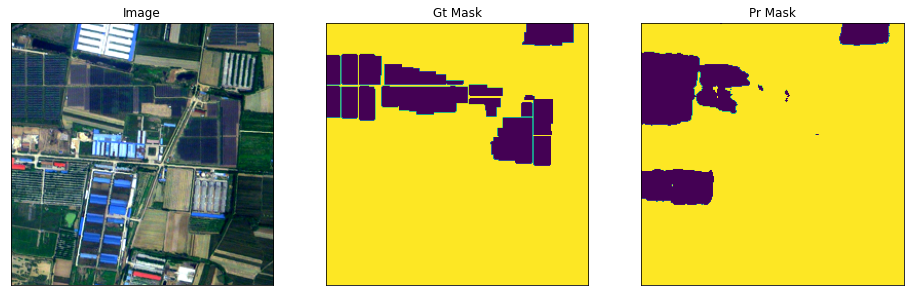

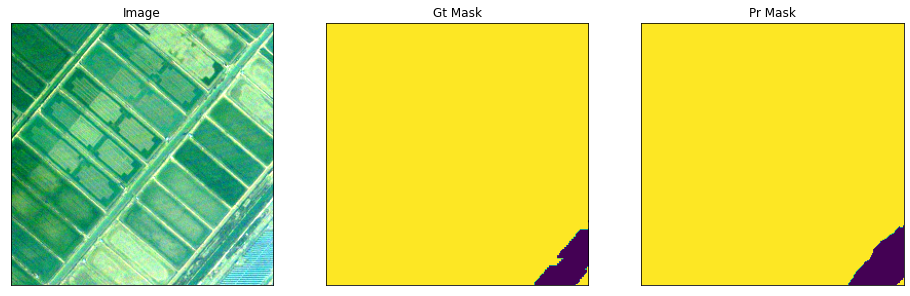

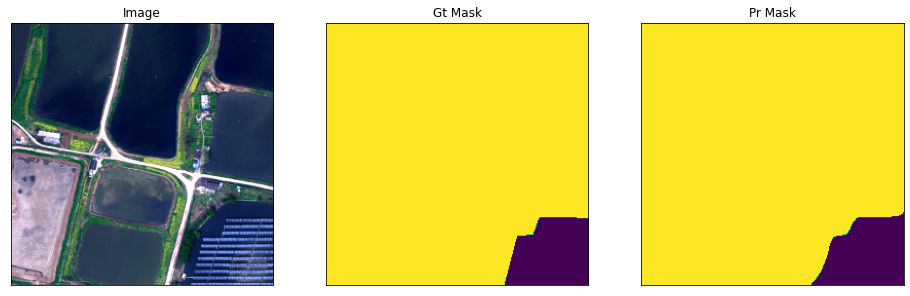

In [28]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )